# Trying to design an automated way to find singletons/outliers

In [1]:
# It's dangerous to go alone, take these
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy.stats import mode, wilcoxon, ranksums, spearmanr, pearsonr, zscore
from scipy.cluster.hierarchy import average, fcluster,linkage,dendrogram
from scipy.spatial.distance import pdist
from sklearn.metrics import f1_score, confusion_matrix, classification_report 
from os import listdir
from collections import defaultdict
%matplotlib inline

clustlist = ['gsea', 'gsva','ora','metaneighbor','adobo','sccatch','cibersort']
celllist =  ['LAmbDA',
             'Cell_BLAST', # this leaves the first and last character of the predictions off, can't use it.
             'RF',
             'kNN9',
             'ACTINN',
             'LDA',
             'LDArej',
             'CaSTLe',
             'scmapcluster',
             'SVM',
             'SingleCellNet',
             'scVI',
             'SVMrej',
             'scmapcell',
             'NMC',
             'singleR',
             'scID',
             'scPred',
             'CHETAH',
            ]

#TODO update to the cell type
dataset_rename = {'cb':'Breast',
                  'dg': 'Glioblastoma',
                  'jam': 'Melanoma',
                  'li': 'Colorectal',
                  'li_crc': 'Colorectal',
                  'llc': 'Lung',
                  'peng': 'Pancreatic',
                  'tm':'Metastatic Melanoma',
                  'vg':'AML',
                 }
#manual from lambrechts
celltypes = ['ERYTHROBLASTS', 
             'BASAL_CELLS', 
             'LYMPHATIC_EC', 
             'SECRETORY_CLUB_CELLS',
             'EPITHELIAL_CELLS', 
             'GRANULOCYTES', 
             'DENDRITIC_CELLS', 
             'MAST_CELLS', 
             'LANGERHANS_CELLS', 
             'ALVEOLAR_CELL', 
             'FIBROBLASTS', 
             'ENDOTHELIAL_CELL', 
             'NATURAL_KILLER_CELLS', 
             'B_CELLS', 
             'CANCER_CELLS', 
             'MACROPHAGES', 
             'T_CELLS', 
            ]

cellrename = {'NK':'NK', 
              'BCELL':"BCELL", 
              'ENDO':"ENDOTHELIAL", 
              'CAF':"CAF", 
              'MACRO':"MACROPHAGE", 
              'TCELL':"TCELL", 
              'UNLABELED':'UNLABELED',
              'TUMOR':"MELANOMA"}
cellrename={}

singletons = []

In [2]:
def get_fulldf(filename, celllist=celllist):
    fulldf = pd.read_csv(filename, sep='\t')
    fulldf = fulldf[fulldf['method'].isin(celllist)]
    support = int(fulldf[(fulldf['method']=='SVM')&(fulldf['class']=='macro avg')]['support'].values[0])
    fulldf['cellprop']=fulldf['support']/support
    #drop unnecessary rows and sort rows from fewest to most cells
    fulldf = fulldf[fulldf['class']!='macro avg']
    fulldf = fulldf[fulldf['class']!='weighted avg']
    fulldf = fulldf[fulldf['class']!='UNLABELED']
    fulldf = fulldf[fulldf['class']!='UNAVAILABLE']
    fulldf = fulldf.sort_values('support',axis=0)
    fulldf['dataset'] = 'original'
    celltypes = list((fulldf[fulldf['method']=='SVM']['class']))
    #make a dictionary we can use to sort the other dataframe
    sortdict = pd.Series(fulldf['support'].values,index=fulldf['class']).to_dict()
    #print(fulldf[fulldf['method']=='SVM'][['support','class']])
    #print(celltypes)
    #print(set(fulldf['class']))
        
    #display(fulldf.head())
    return fulldf, sortdict

In [3]:
def compare_subsampled(filename, fulldf, sortdict,celllist=celllist,cellrename=cellrename):
    title = filename.split('.')[0]
    title = title.split('/')[1]
    plotdir = title.split('_')[0]+"_plots"
    #subsampled file and empty dictionary for the performance
    llc_subsample = pd.read_csv(filename, sep='\t')
    #print(set(llc_subsample['truth']))
    perfdf = pd.DataFrame(columns = ['method', 
                                     'class', 
                                     'precision', 
                                     'recall', 
                                     'f1_score', 
                                     'support', 
                                     'specificity'])
    
    # for each method that we're testing, compute a score and add it to a new dataframe
    llc_subsample['truth'] = llc_subsample.apply(lambda row: cellrename[row['truth']] if row['truth'] in cellrename.keys() else row['truth'],axis=1)
    for method in celllist:
        if method == "scPred" and title == "Lambrechts_LC_1600":
            fulldf = fulldf[fulldf['method']!="scPred"]
            continue
        #llc_subsample[method] = llc_subsample.apply(lambda row: cellrename[row[method]],axis=1)
        llc_subsample[method] = llc_subsample.apply(lambda row: cellrename[row[method]] if row[method] in cellrename.keys() else row[method],axis=1)
        report = classification_report(y_true=llc_subsample.truth,
                                       y_pred=llc_subsample[f'{method}'],
                                       output_dict=True)
        cm = confusion_matrix(y_true=llc_subsample.truth,
                              y_pred=llc_subsample[f'{method}'])
        #compute scores from confusion matrix
        FP = cm.sum(axis=0)-np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        class_spec = TN/(TN+FP)
        i = 0
        for key, val in report.items():
            if key =='accuracy': 
                continue
            perflist = []
            perflist.append(method)
            perflist.append(key)
            for key2, val2 in val.items():
                perflist.append(val2)
            if i>=len(class_spec):
                perflist.append(0)
            else:
                perflist.append(class_spec[i])
            perfdf=perfdf.append(pd.Series(perflist, index=perfdf.columns), ignore_index=True)
            i+=1
            
    #TODO modify this in the new script to have a computed value instead of a hardcoded one 
    perfdf = perfdf[perfdf['class']!='macro avg']
    perfdf = perfdf[perfdf['class']!='weighted avg']
    perfdf = perfdf[perfdf['class']!='UNLABELED']
    if len(set(perfdf['support'])) != 1:
        print("ERROR: Not all rows have the same number of cells")
        display(perfdf)
    support = set(perfdf['support']).pop()
    total_cells = len(set(perfdf['class']))*support
    print(f"Total cells in dataset: {total_cells}")
    #print(set(perfdf['class']))
    perfdf['cellprop']=perfdf['support']/total_cells
    #display(perfdf.head())
    
    
    ####################################
    # Boxplots of cell type side by side
    ####################################
    
    #make a sorting column from the number of cells in the original dataframe and sort by it
    perfdf['sorting'] = perfdf.apply(lambda row: sortdict[row['class']],axis=1)
    perfdf = perfdf.sort_values('sorting',axis=0)
    
    
    fig,(ax1,ax2) = plt.subplots(1,2,dpi=200)
    bxplt_l = sns.boxplot(y='class', x='f1_score',data=fulldf,ax=ax1)
    bxplt_l.set_xlim(-0.05,1.05)
    bxplt_l.set_title('Lambrechts Original')
    bxplt = sns.boxplot(y='class', x='f1_score',data=perfdf,ax=ax2)
    bxplt.set_xlim(-0.05,1.05)
    bxplt.set_title('Lambrechts Balanced')
    bxplt.tick_params(labelleft=False, left=False)
    bxplt.set_ylabel("")
    fig.set_figwidth(16)
    fig.tight_layout()
    plt.close()
    
    
    
    ###########################################
    # Test differences between groups with wilcoxon
    ###########################################
    medians = []
    stds = []
    vars = []
    medians_b = []
    stds_b = []
    vars_b = []
    siglist = []
    for celltype in sortdict.keys():
        #print(f"--------{celltype}--------")
        original_list = fulldf[fulldf['class']==celltype]['f1_score'].values
        #display(fulldf[fulldf['class']==celltype])
        balanced_list = perfdf[perfdf['class']==celltype]['f1_score'].values
        #display(perfdf[perfdf['class']==celltype])
        stat,pval = wilcoxon(balanced_list,original_list,alternative='greater')
       
        #print(f"Original Variance = {np.var(original_list)}")
        vars.append(np.var(original_list))
        #print(f"Balanced Variance = {np.var(balanced_list)}")
        vars_b.append(np.var(balanced_list))
        
        #print(f"Original Standard deviation = {np.std(original_list)}")
        stds.append(np.std(original_list))
        #print(f"Balanced Standard deviation = {np.std(balanced_list)}")
        stds_b.append(np.std(balanced_list))
        
        #print(f"Original median = {np.median(original_list)}")
        medians.append(np.median(original_list))
        #print(f"Balanced median = {np.median(balanced_list)}")
        medians_b.append(np.median(balanced_list))
        
        if pval < 0.05:
            siglist.append(celltype)
            #print(f"Group F-measures are different! p = {pval}")
        else:
            dummyvar = 3*3
            #print(f"Group F-measures are not different, p = {pval}")
        #print(original_list)
        #print(balanced_list)
        #print()
        
    #print()
    stat, pval = wilcoxon(medians_b,medians,alternative='greater')
    if pval < 0.05:
        dummyvar = 3*3
        #print("Medians of the two groups are different, p = ", pval)
    else:
        dummyvar = 3*3
        #print("Medians of the two groups are not different, p = ", pval)
    stat, pval = wilcoxon(stds_b,stds,alternative='less')
    if pval < 0.05:
        dummyvar = 3*3
        #print("Standard deviations of the two groups are different, p = ", pval)
    else:
        dummyvar = 3*3
        #print("Standard deviations of the two groups are not different, p = ", pval)
    stat, pval = wilcoxon(vars_b,vars,alternative='less')
    if pval < 0.05:
        dummyvar = 3*3
        #print("Variances of the two groups are different, p = ", pval)
    else:
        dummyvar = 3*3
        #print("Variances of the two groups are not different, p = ", pval)
        
    ###############################
    # Plot differences between groups
    ###############################
    perfdf['dataset'] = 'balanced'
    plotdf = fulldf.append(perfdf[fulldf.columns], ignore_index=True)
    #display(plotdf[plotdf['dataset']=='original'])
    sizedict = pd.Series(plotdf[plotdf['dataset']=='original']['support'].values,
                         index=plotdf[plotdf['dataset']=='original']['class']).to_dict() 
    #print(sizedict)
    plotdf['sort'] = plotdf.apply(lambda row: sizedict[row['class']],axis=1)
    plotdf['class'] = plotdf.apply(lambda row: f"{row['class']} ({int(sizedict[row['class']])})",axis=1)
    plotdf = plotdf.sort_values('sort')
    
    fig,ax = plt.subplots(1,1,dpi=200)
    bxplt_l = sns.boxplot(x='class', y='f1_score',data=plotdf,hue='dataset',ax=ax)
    bxplt_l.set_ylim(-0.05,1.05)
    bxplt_l.set_title(f'{title.split("_")[0]} Original vs Balanced ({title.split("_")[2]} Cells)')
    bxplt_l.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    bxplt_l.set_ylabel('F Measure')
    bxplt_l.set_xlabel('Cell Type')
    fig.set_figheight(3)
    fig.set_figwidth(10)
    fig.tight_layout()
    for i in bxplt_l.get_xticklabels():
        if i.get_text().split(' ')[0] in siglist:
            i.set_color("Brown")
    bxplt_l.set_xticklabels(bxplt_l.get_xticklabels(),
                            rotation=45,
                            horizontalalignment='right',
                           )
    #plt.savefig(f'{plotdir}/{title}_balanced_boxplot.png', bbox_inches='tight')
    #plt.show()
    plt.close()
    
    ######################################
    # Plot differences per algorithm
    #####################################
    tempdf = perfdf.merge(fulldf, on=['method','class'])
    tempdf['difference'] = tempdf['f1_score_x'] - tempdf['f1_score_y'] #balanced - original
    minrange = tempdf['difference'].min()-0.05
    #display(tempdf[tempdf['difference']==minrange+0.05])
    maxrange = tempdf['difference'].max()+0.05
    #display(tempdf[tempdf['difference']==maxrange-0.05])
    
    ##tempdf['abs_diff']=abs(tempdf['difference'])
    ##newbx = sns.boxplot(data=tempdf, x='method',y='abs_diff')
    ##newbx.set_xticklabels(newbx.get_xticklabels(),rotation=45,horizontalalignment='right')
    ##plt.show()
    
    
    fig, axes = plt.subplots(7,3)
    
    celltypes = list((fulldf[fulldf['method']=='SVM']['class']))
    hmdf = pd.DataFrame(index=celltypes)
    #print(list(set(plotdf['method'])))
    for method,ax in zip(list(set(plotdf['method'])),axes.flatten()):
        tempdf = perfdf[perfdf['method']==method][['class','f1_score']].merge(fulldf[fulldf['method']==method][['class','f1_score']], on='class',)
        tempdf['difference'] = tempdf['f1_score_x'] - tempdf['f1_score_y'] #balanced - original
        #save the difference in a dataframe we can use for a heatmap later
        hmdf[method]=tempdf.set_index('class')['difference'].copy()
        #tempdf = tempdf.sort_values(by='difference')
        method_plot = sns.barplot(y='class',
                                  x='difference',
                                  data=tempdf,
                                  ax=ax,
                                 )
        method_plot.set_title(method)
        method_plot.set_xlabel('Difference between balanced and original data')
        method_plot.set_xlim(minrange,maxrange)
        method_plot.axvline(0, color="black",linewidth=0.5)
        #method_plot.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    
    fig.set_figheight(36)
    fig.set_figwidth(18)
    plt.tight_layout()
    #plt.savefig(f'{plotdir}/{title}_per_algorithm_change.png',bbox_inches='tight')
    plt.close()
    
    
    hmdf = hmdf.T
    
    #Find linkage distances and display a dendrogram
    z = linkage(hmdf,method='average')
    dn = dendrogram(z,color_threshold=0.6*max(z[:,2]))
    
    # get the colors for each algorithm from the dendrogram
        # https://stackoverflow.com/questions/61959602/retrieve-leave-colors-from-scipy-dendrogram
    singleton_i = []
    points = dn['leaves']
    colors = ['none'] * len(points)
    for xs, c in zip(dn['icoord'], dn['color_list']):
        for xi in xs:
            if xi % 10 == 5:
                colors[(int(xi)-5) // 10] = c
                
    #if a points color isn't the same as the biggest group, it is a singleton
    groupcolor = max(set(colors), key = colors.count)
    for point, color in zip(points,colors):
        if color != groupcolor:
            singleton_i.append(point)
            #print(f'point: {point}, colour: {color}')
            
    #print(singleton_i)
    singletons = hmdf.iloc[singleton_i].index.values
    plt.show()
    hm2 = sns.clustermap(hmdf,
                         figsize=(14,14),
                         z_score=None,
                         standard_scale=None,
                         row_cluster=True,
                         row_linkage=z,
                         col_cluster=False,
                         cmap='coolwarm', 
                         annot=True,
                         center=0,
                         #vmin = -0.59,
                         #vmax = 1.0,
                         fmt="1.2f"
                         )
    for l in hm2.ax_heatmap.get_yticklabels():
        if l.get_text() in singletons:
            l.set_color("Brown")
    #plt.savefig(f'./{plotdir}/heatmaps/{title}_clustered_heatmap.png', bbox_inches='tight')
    plt.show()
    
    
    ########################################################################
    # TEST REMOVING RARE CELLS
    ########################################################################
    testdf = fulldf[fulldf['method']=='SVM'][['class','support','cellprop']]
    rarecells = testdf[((testdf['support']<=150)&(testdf['cellprop']<=0.05))|(testdf['cellprop']<=0.01)]
    display(rarecells)
    rarecells = rarecells['class'].values
    hmdf2 = hmdf[[column for column in hmdf.columns if column not in rarecells]]
    
    
    z = linkage(hmdf2,method='average')
    dn = dendrogram(z,color_threshold=0.6*max(z[:,2]))
    
    # get the colors for each algorithm from the dendrogram
        # https://stackoverflow.com/questions/61959602/retrieve-leave-colors-from-scipy-dendrogram
    singleton_i = []
    points = dn['leaves']
    colors = ['none'] * len(points)
    for xs, c in zip(dn['icoord'], dn['color_list']):
        for xi in xs:
            if xi % 10 == 5:
                colors[(int(xi)-5) // 10] = c
                
    #if a points color isn't the same as the biggest group, it is a singleton
    groupcolor = max(set(colors), key = colors.count)
    for point, color in zip(points,colors):
        if color != groupcolor:
            singleton_i.append(point)
            #print(f'point: {point}, colour: {color}')
            
    #print(singleton_i)
    singletons = hmdf2.iloc[singleton_i].index.values
    plt.show()
    hm2 = sns.clustermap(hmdf2,
                         figsize=(14,14),
                         z_score=None,
                         standard_scale=None,
                         row_cluster=True,
                         row_linkage=z,
                         col_cluster=False,
                         cmap='coolwarm', 
                         annot=True,
                         center=0,
                         #vmin = -0.59,
                         #vmax = 1.0,
                         fmt="1.2f"
                         )
    for l in hm2.ax_heatmap.get_yticklabels():
        if l.get_text() in singletons:
            l.set_color("Brown")
    #plt.savefig(f'./{plotdir}/heatmaps/{title}_clustered_heatmap.png', bbox_inches='tight')
    plt.show()
    
    
    
    #perfdf.to_csv(f"./performance/{filename.split('/')[1]}", sep='\t',index=False)
    
    return hmdf, hmdf2

jam_classification_report.tsv
6879
li_crc_classification_report.tsv
359
dg_classification_report.tsv
3589
llc_classification_report.tsv
51775.0
tm_classification_report.tsv
4097
cb_classification_report.tsv
486
peng_classification_report.tsv
57530.0
vg_classification_report.tsv
21933.0


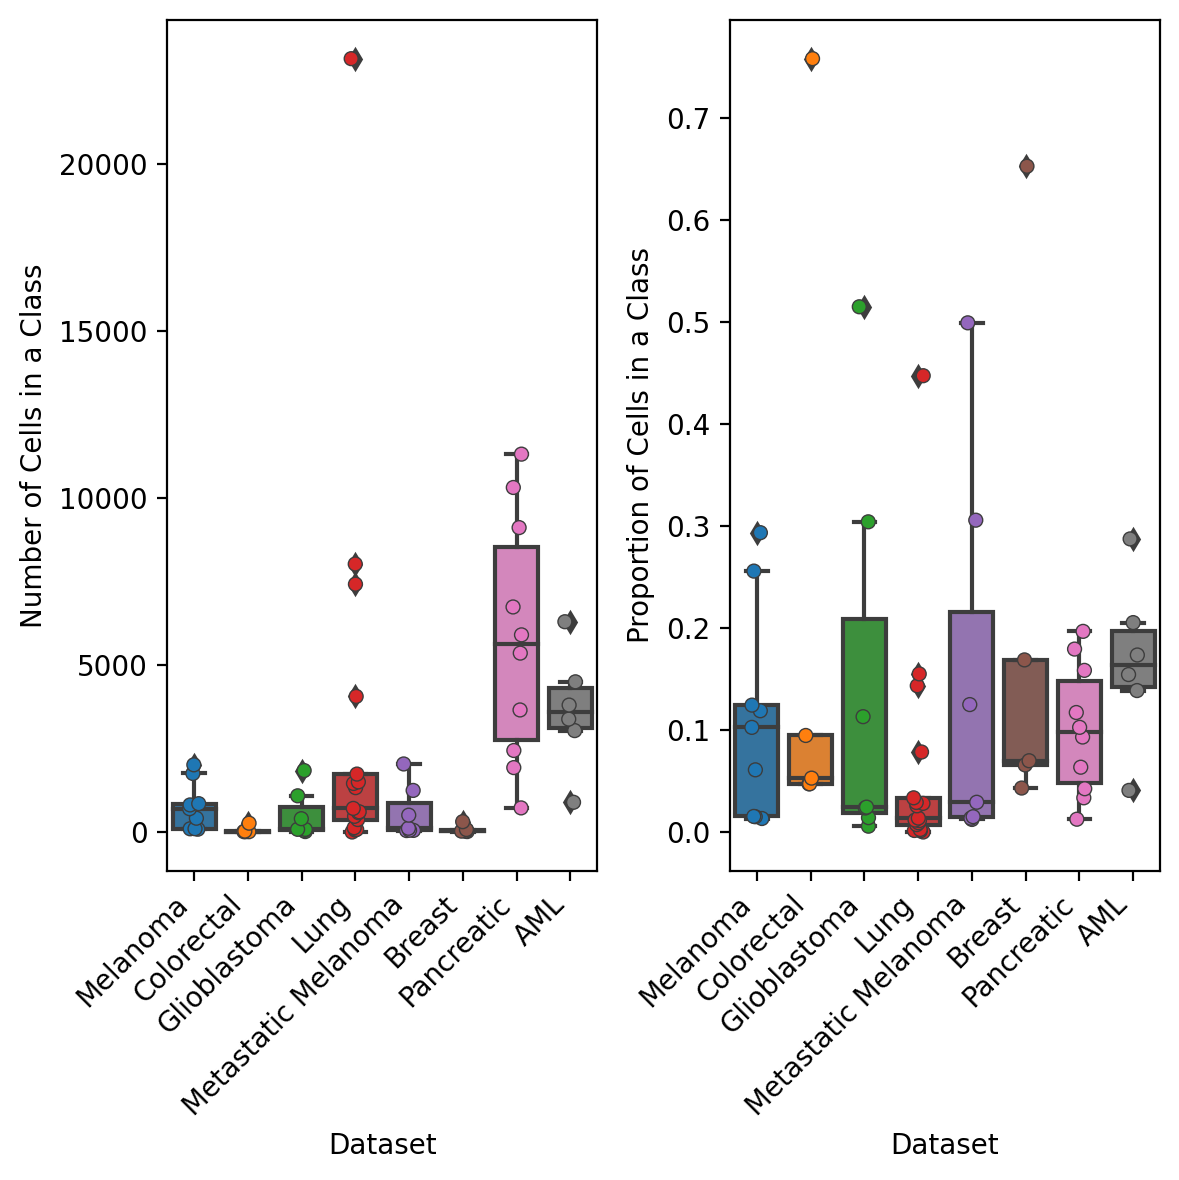

710.0
0.062337183679134704
count    66.000000
mean      0.121212
std       0.157022
min       0.000155
25%       0.015202
50%       0.062337
75%       0.154872
max       0.757660
Name: cellprop, dtype: float64


In [4]:
datadir = "/Users/erik/Documents/school/research/labelling_project/performance/seurat/"
alldf = pd.DataFrame()
for file in listdir(datadir):
    if "classification_report" in file:
        print(file)
        filepath = datadir + file
        df = pd.read_csv(filepath,sep='\t')
        #df = df[df['method'].isin(celllist)]
        df = df[df['method']=='SVM']
        numcells = df[df['class']=='macro avg']['support'].values[0]
        print(numcells)
        df['cellprop'] = df['support']/numcells
        df = df.sort_values('support',axis=0)
        df = df[df['class']!='macro avg']
        df = df[df['class']!='weighted avg']
        df = df[df['class']!='UNLABELED']
        df['dataset'] = dataset_rename[file.split('_')[0]]
        alldf = alldf.append(df)
        #display(df)
        
        
fig, (ax1, ax2) = plt.subplots(1,2,dpi=200)
b1 = sns.boxplot(y='support',x='dataset',data=alldf,ax=ax1,saturation=0.7)
b1.set_xticklabels(b1.get_xticklabels(),rotation=45, horizontalalignment='right')
s1 = sns.stripplot(y='support',x='dataset',data=alldf,ax=ax1,linewidth=0.5)
ax1.set_ylabel('Number of Cells in a Class')
ax1.set_xlabel('Dataset')

b2 = sns.boxplot(y='cellprop',x='dataset',data=alldf,ax=ax2,saturation=0.7)
b2.set_xticklabels(b2.get_xticklabels(),rotation=45, horizontalalignment='right')
s2 = sns.stripplot(y='cellprop',x='dataset',data=alldf,ax=ax2,linewidth=0.5)
ax2.set_ylabel('Proportion of Cells in a Class')
ax2.set_xlabel('Dataset')

fig.set_figheight(6)
fig.tight_layout()
#TODO savefig
plt.savefig('../supplemental/imbalanced_boxes.png')
plt.show()
print(alldf['support'].median())
print(alldf['cellprop'].median())
print(alldf['cellprop'].describe())

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 13600


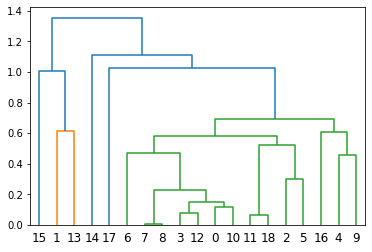

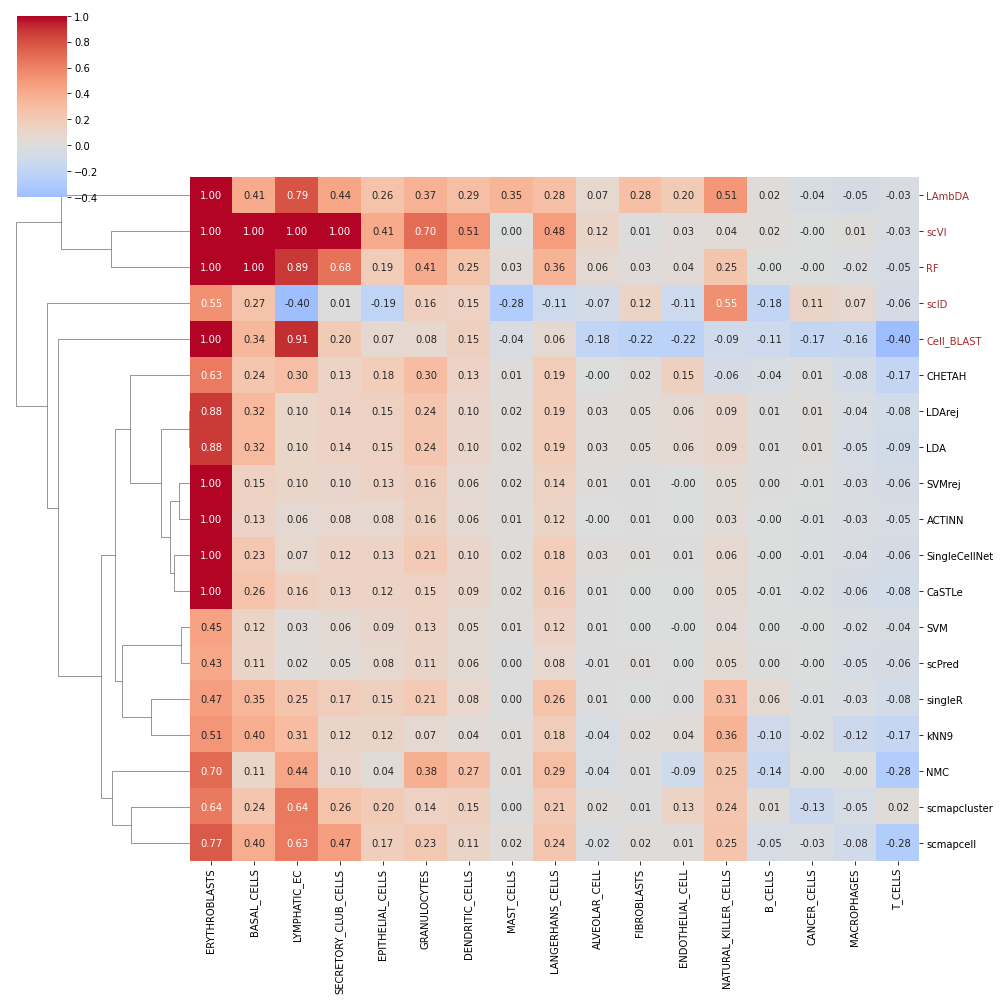

,class,support,cellprop
142,ERYTHROBLASTS,8.0,0.000155
136,BASAL_CELLS,68.0,0.001313
146,LYMPHATIC_EC,85.0,0.001642
150,SECRETORY_CLUB_CELLS,135.0,0.002607
141,EPITHELIAL_CELLS,381.0,0.007359
144,GRANULOCYTES,477.0,0.009213


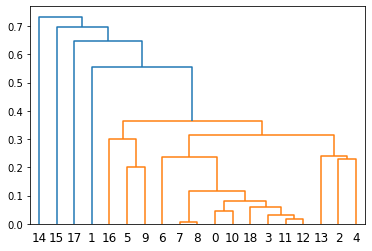

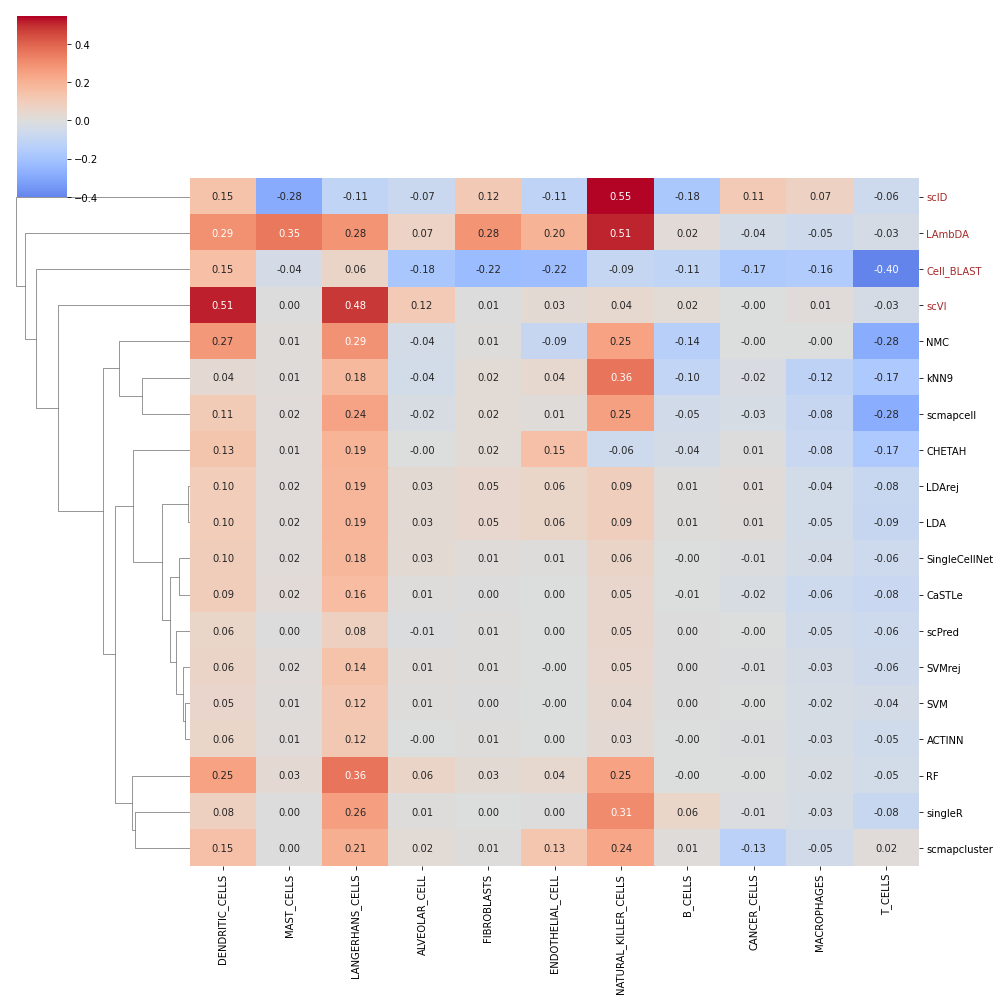

In [5]:
fulldf,sortdict = get_fulldf("/Users/erik/Documents/school/research/labelling_project/performance/seurat/llc_classification_report.tsv")
#cellrename = defaultdict(lambda)
hmdf,hmdf2 = compare_subsampled('data/Lambrechts_LC_800.tsv',fulldf,sortdict)
# (500 & .15) | .01
med_abs_df = pd.DataFrame()
mean_abs_df = pd.DataFrame()
med_abs_df2 = pd.DataFrame()
mean_abs_df2 = pd.DataFrame()
med_abs_df['Lung'] = hmdf.abs().median(axis=1)
mean_abs_df['Lung'] = hmdf.abs().mean(axis=1)
med_abs_df2['Lung'] = hmdf2.abs().median(axis=1)
mean_abs_df2['Lung'] = hmdf2.abs().mean(axis=1)

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 8000


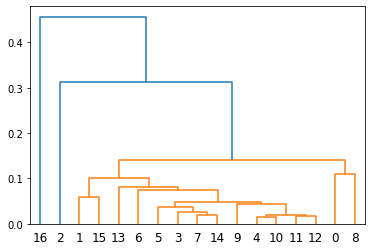

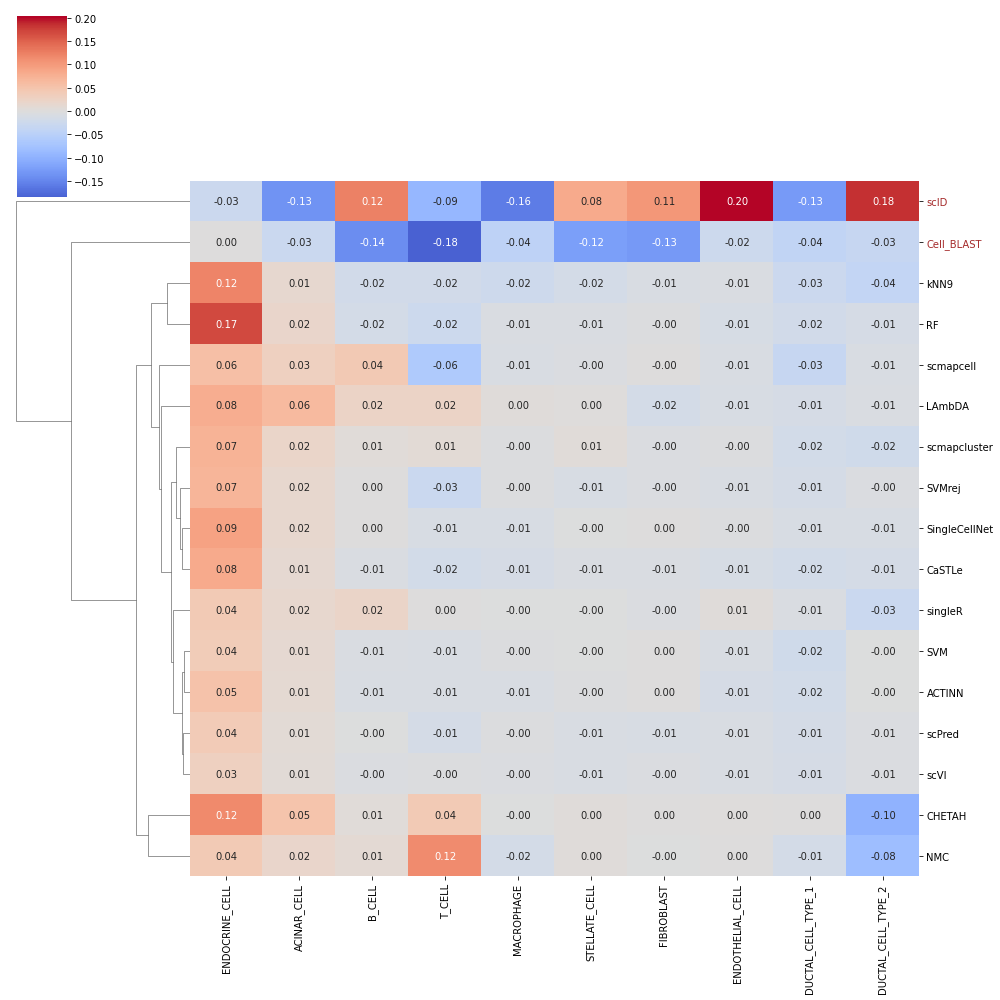

,class,support,cellprop


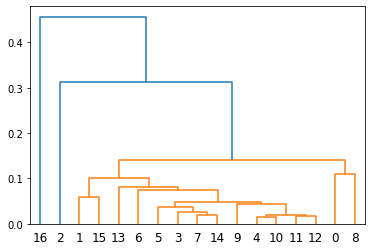

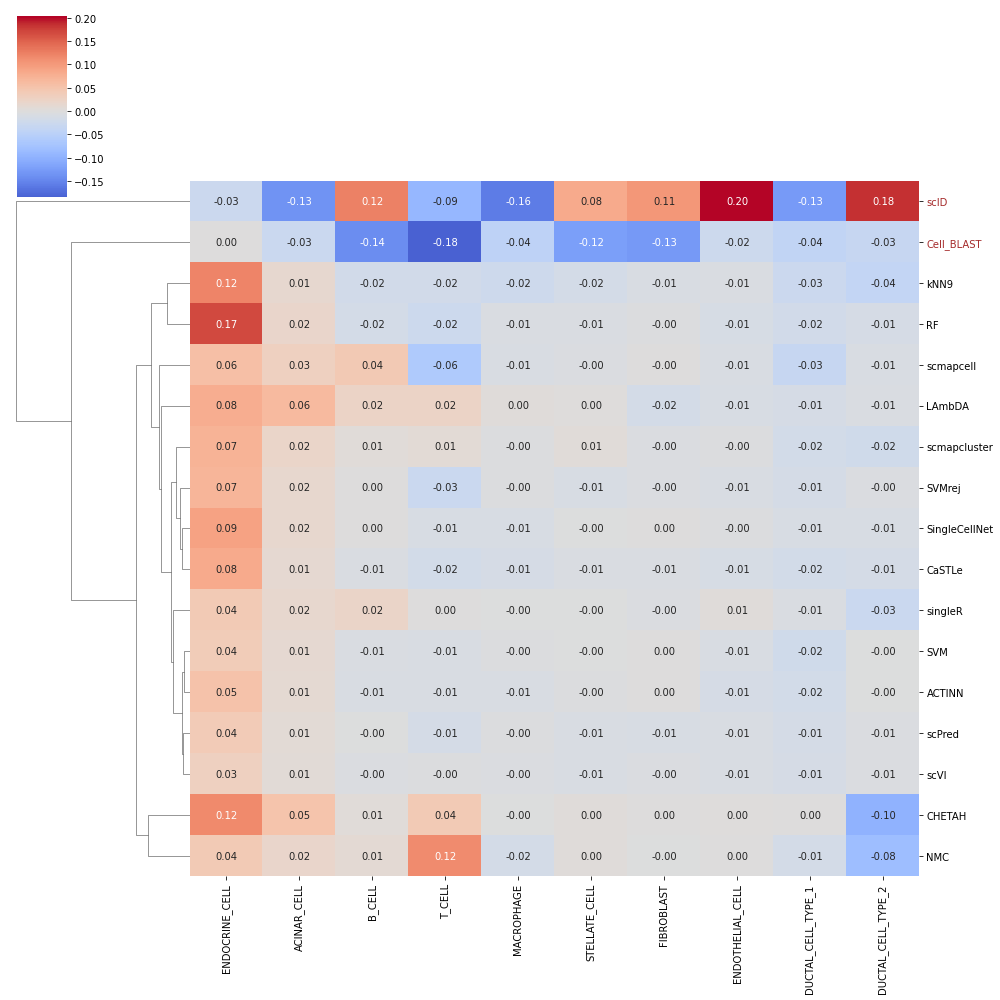

In [6]:
pcelllist =  ['LAmbDA',
             'Cell_BLAST', # this leaves the first and last character of the predictions off, can't use it.
             'RF',
             'kNN9',
             'ACTINN',
             #'LDA',
             #'LDArej',
             'CaSTLe',
             'scmapcluster',
             'SVM',
             'SingleCellNet',
             'scVI',
             'SVMrej',
             'scmapcell',
             'NMC',
             'singleR',
             'scID',
             'scPred',
             'CHETAH',
            ]
fulldf,sortdict = get_fulldf("/Users/erik/Documents/school/research/labelling_project/performance/seurat/peng_classification_report.tsv",pcelllist)
#cellrename = defaultdict(lambda)
hmdf,hmdf2 = compare_subsampled('data/Peng_PC_800.tsv',fulldf,sortdict,pcelllist)
med_abs_df['Pancreatic'] = hmdf.abs().median(axis=1)
mean_abs_df['Pancreatic'] = hmdf.abs().mean(axis=1)
med_abs_df2['Pancreatic'] = hmdf2.abs().median(axis=1)
mean_abs_df2['Pancreatic'] = hmdf2.abs().mean(axis=1)

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 4800


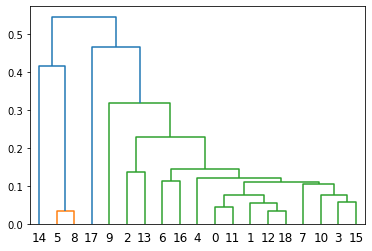

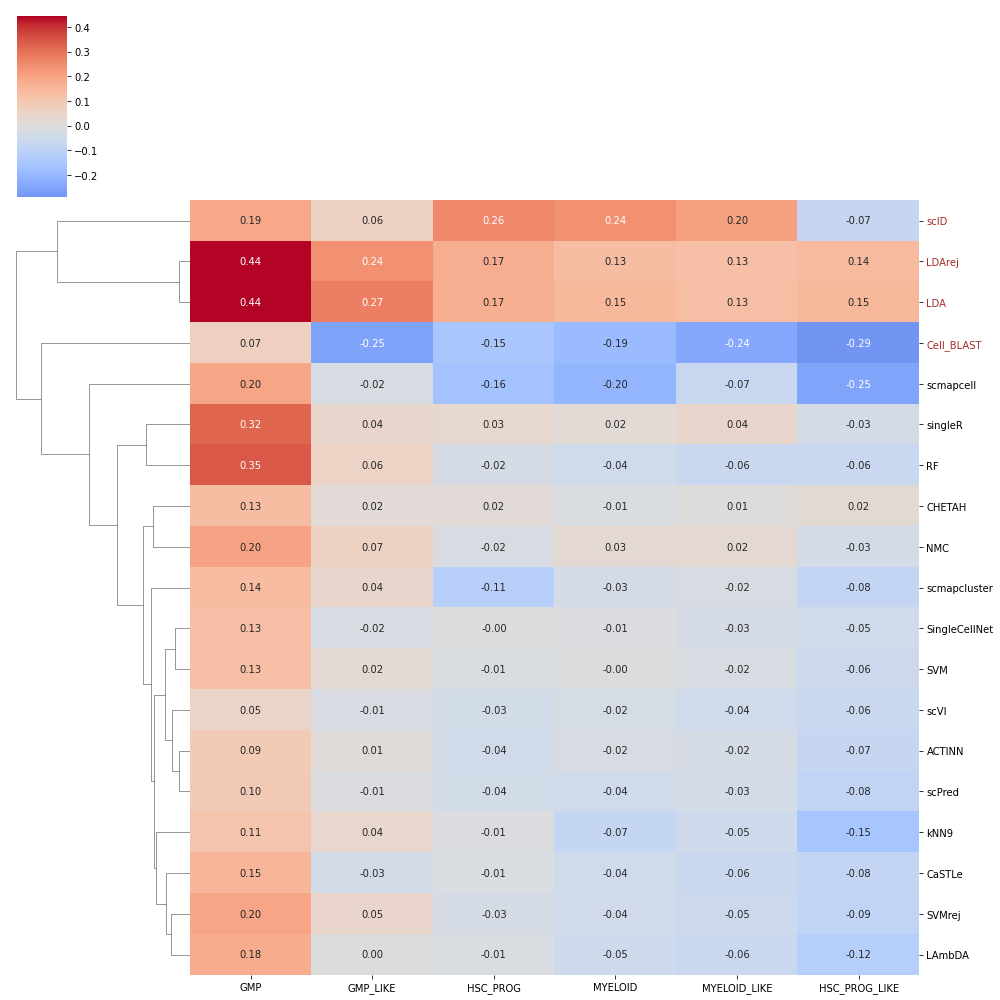

,class,support,cellprop


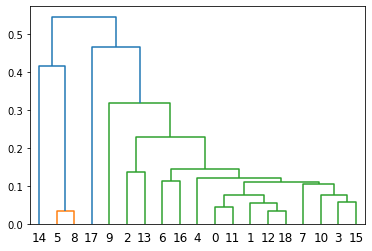

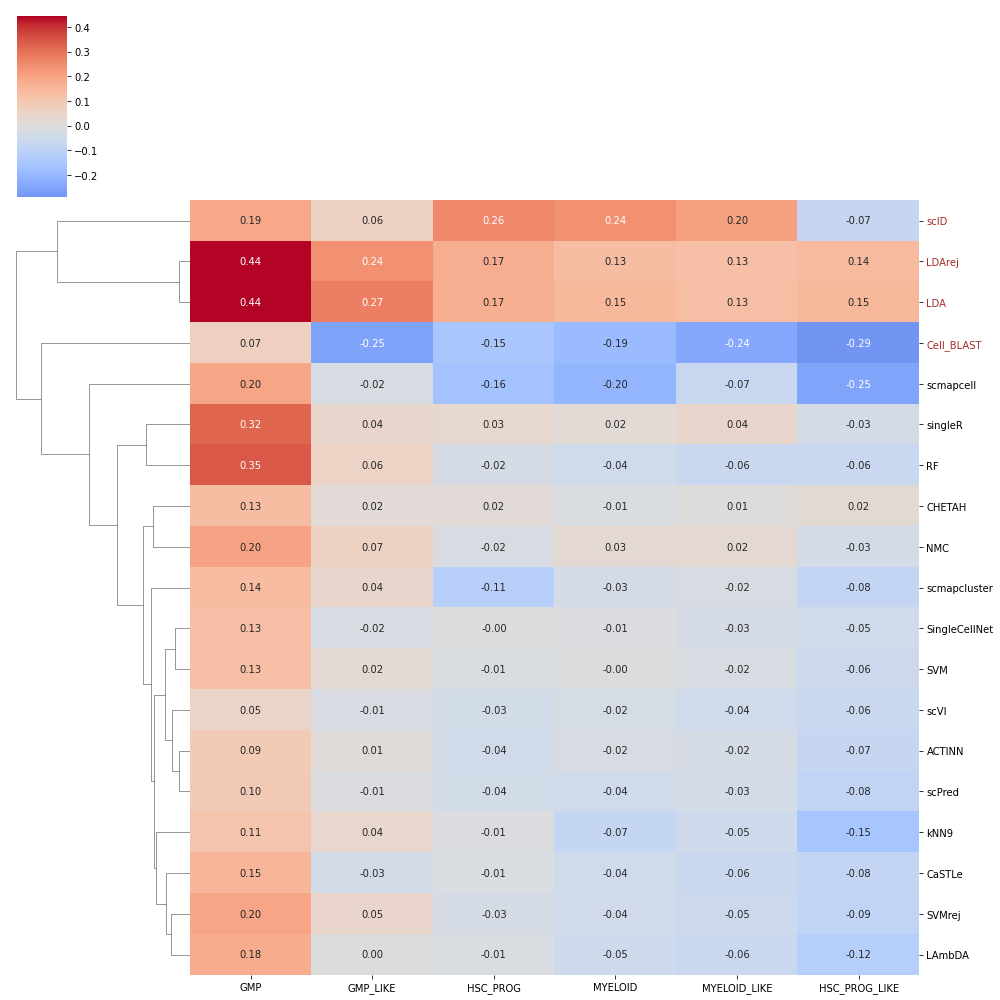

In [7]:
fulldf,sortdict = get_fulldf("/Users/erik/Documents/school/research/labelling_project/performance/seurat/vg_classification_report.tsv")
#cellrename = defaultdict(lambda)
hmdf,hmdf2 = compare_subsampled('data/vanGalan_AML_800.tsv',fulldf,sortdict)
med_abs_df['AML'] = hmdf.abs().median(axis=1)
mean_abs_df['AML'] = hmdf.abs().mean(axis=1)
med_abs_df2['AML'] = hmdf2.abs().median(axis=1)
mean_abs_df2['AML'] = hmdf2.abs().mean(axis=1)

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 5600


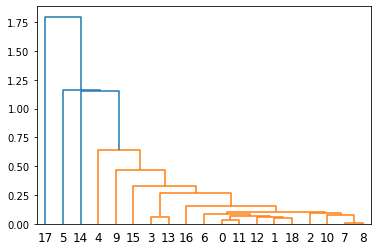

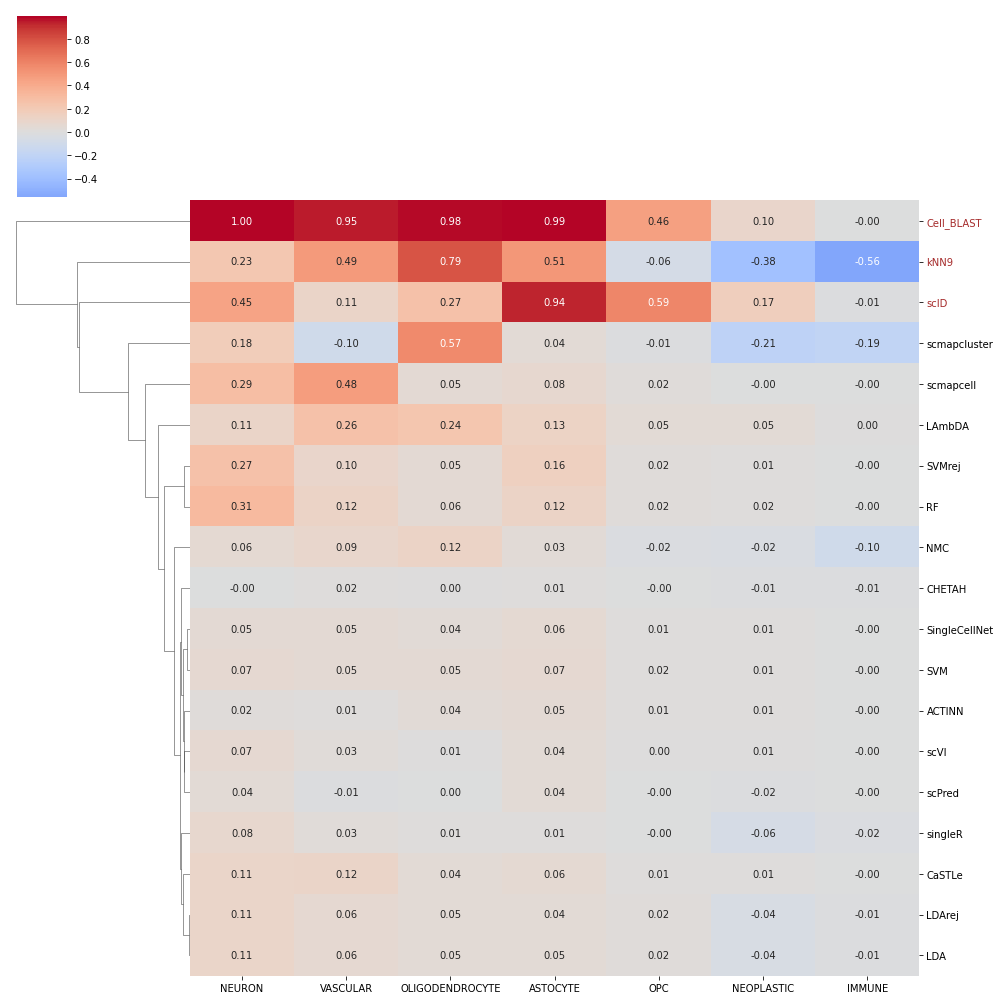

,class,support,cellprop
68,NEURON,21,0.005851
71,VASCULAR,51,0.014210
69,OLIGODENDROCYTE,85,0.023683
65,ASTOCYTE,88,0.024519


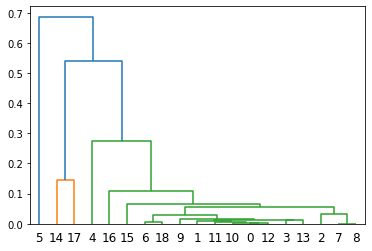

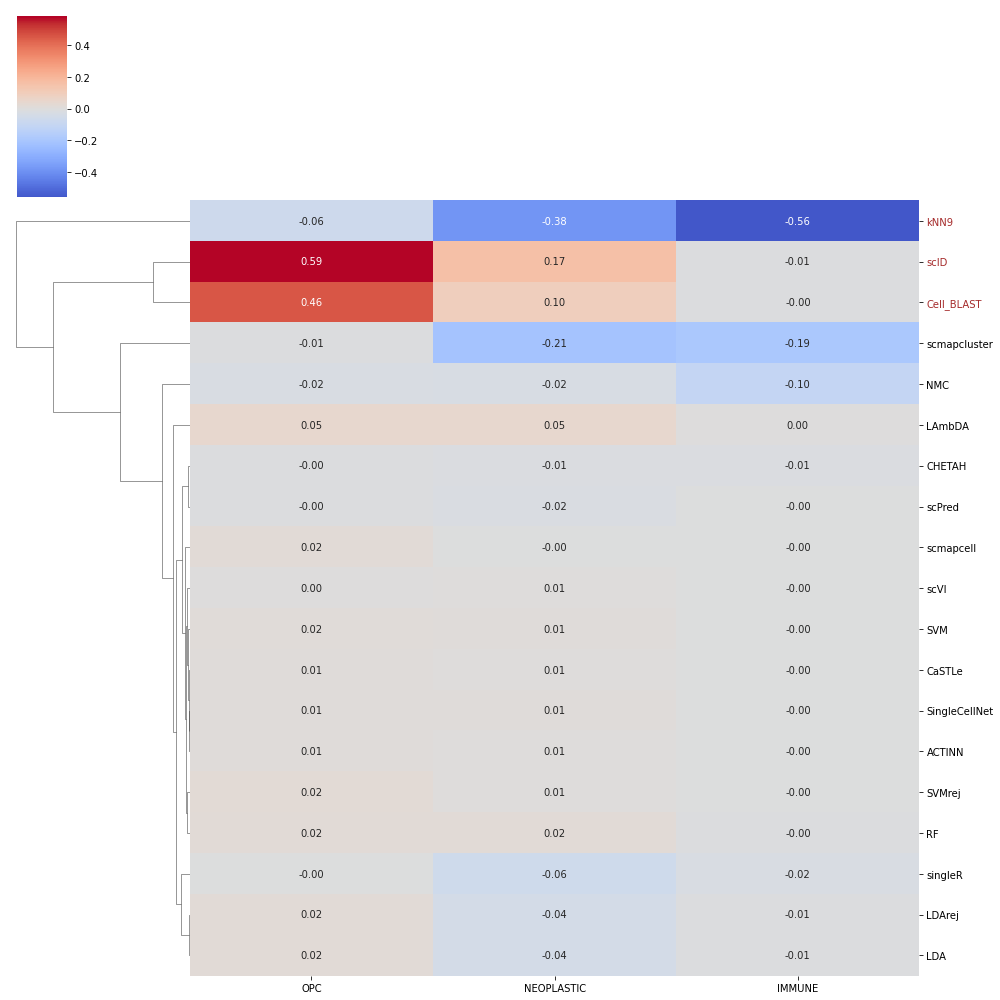

In [8]:
fulldf,sortdict = get_fulldf("/Users/erik/Documents/school/research/labelling_project/performance/seurat/dg_classification_report.tsv")
#cellrename = defaultdict(lambda)
cellrename2 = {'IMMUNE_CELL':'IMMUNE',
              'NEURON':'NEURON', 
              'OPC':'OPC', 
              'OLIGODENDROCYTE':'OLIGODENDROCYTE', 
              'ASTOCYTE':'ASTOCYTE', 
              'NEOPLASTIC':'NEOPLASTIC', 
              'VASCULAR':'VASCULAR',
              'UNLABELED':'UNLABELED'
             }
hmdf,hmdf2 = compare_subsampled('data/Darmanis_GBM_800.tsv',fulldf,sortdict,cellrename=cellrename2)
med_abs_df['Glioblastoma'] = hmdf.abs().median(axis=1)
mean_abs_df['Glioblastoma'] = hmdf.abs().mean(axis=1)
med_abs_df2['Glioblastoma'] = hmdf2.abs().median(axis=1)
mean_abs_df2['Glioblastoma'] = hmdf2.abs().mean(axis=1)

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 7200


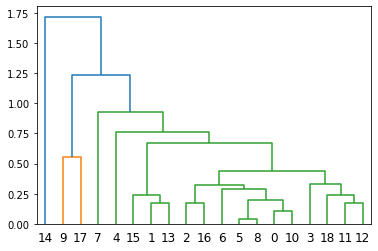

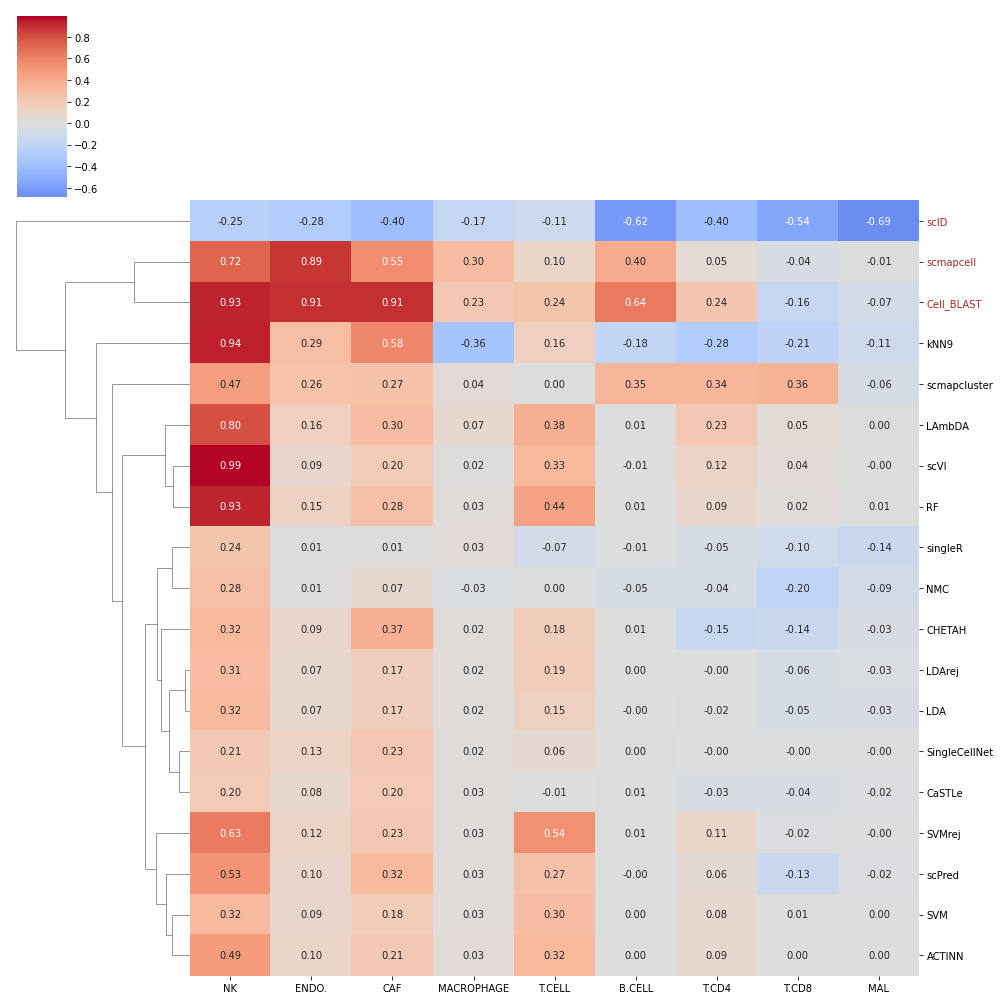

,class,support,cellprop
84,NK,92,0.013374
81,ENDO.,104,0.015118
80,CAF,106,0.015409


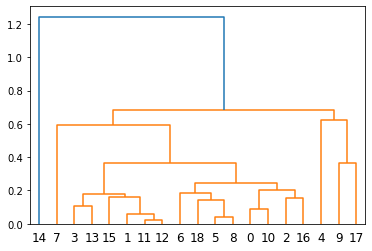

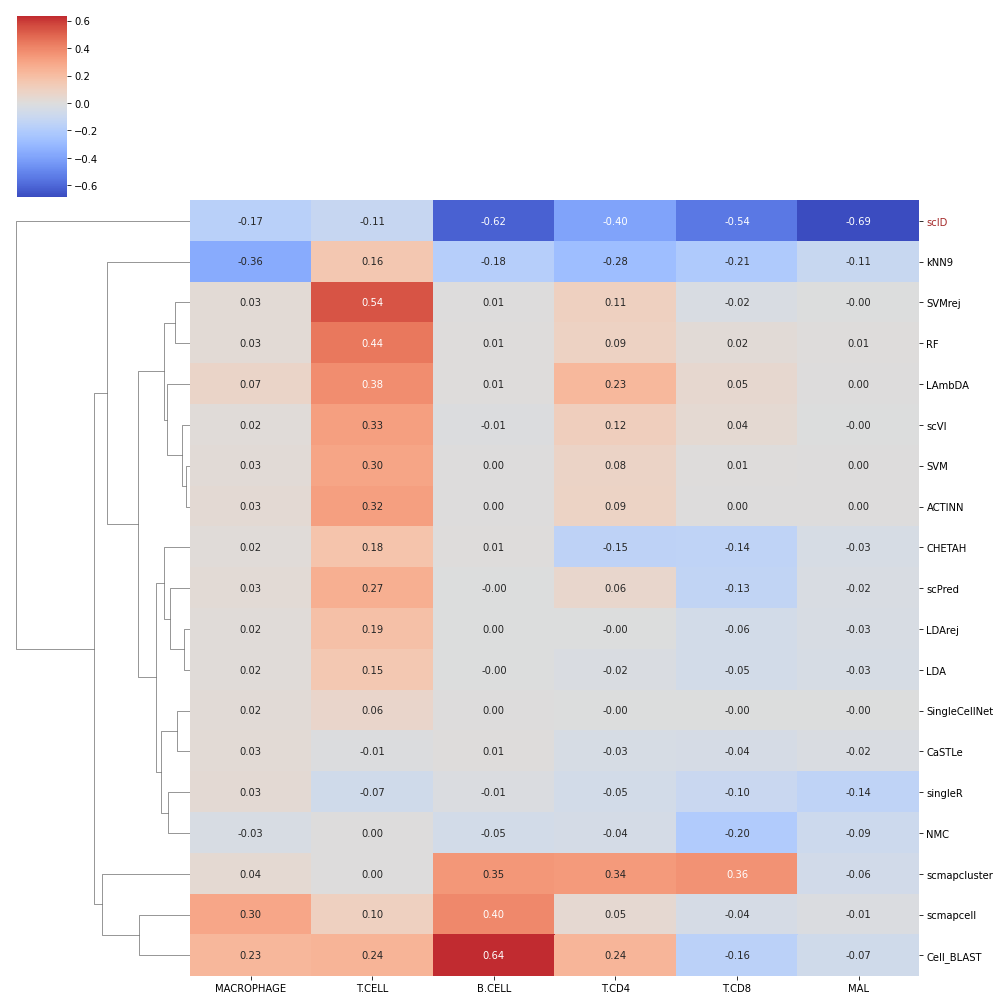

In [9]:
fulldf,sortdict = get_fulldf("/Users/erik/Documents/school/research/labelling_project/performance/seurat/jam_classification_report.tsv")
#cellrename = defaultdict(lambda)
cellrename2 = {'TUMOR':'MAL', 
              'T.CD8':'T.CD8', 
              'T.CD4':'T.CD4', 
              'NK':'NK', 
              'TCELL':'T.CELL', 
              'ENDO.':'ENDO.', 
              'CAF':'CAF', 
              'BCELL':'B.CELL', 
              'UNLABELED':'UNLABELED',
              'MACROPHAGE':'MACROPHAGE'}
hmdf,hmdf2 = compare_subsampled('data/JA_Melanoma_800.tsv',fulldf,sortdict,cellrename=cellrename2)
med_abs_df['Melanoma'] = hmdf.abs().median(axis=1)
mean_abs_df['Melanoma'] = hmdf.abs().mean(axis=1)
med_abs_df2['Melanoma'] = hmdf2.abs().median(axis=1)
mean_abs_df2['Melanoma'] = hmdf2.abs().mean(axis=1)

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total cells in dataset: 5600


/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


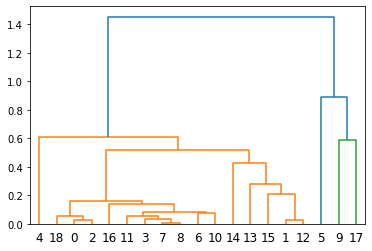

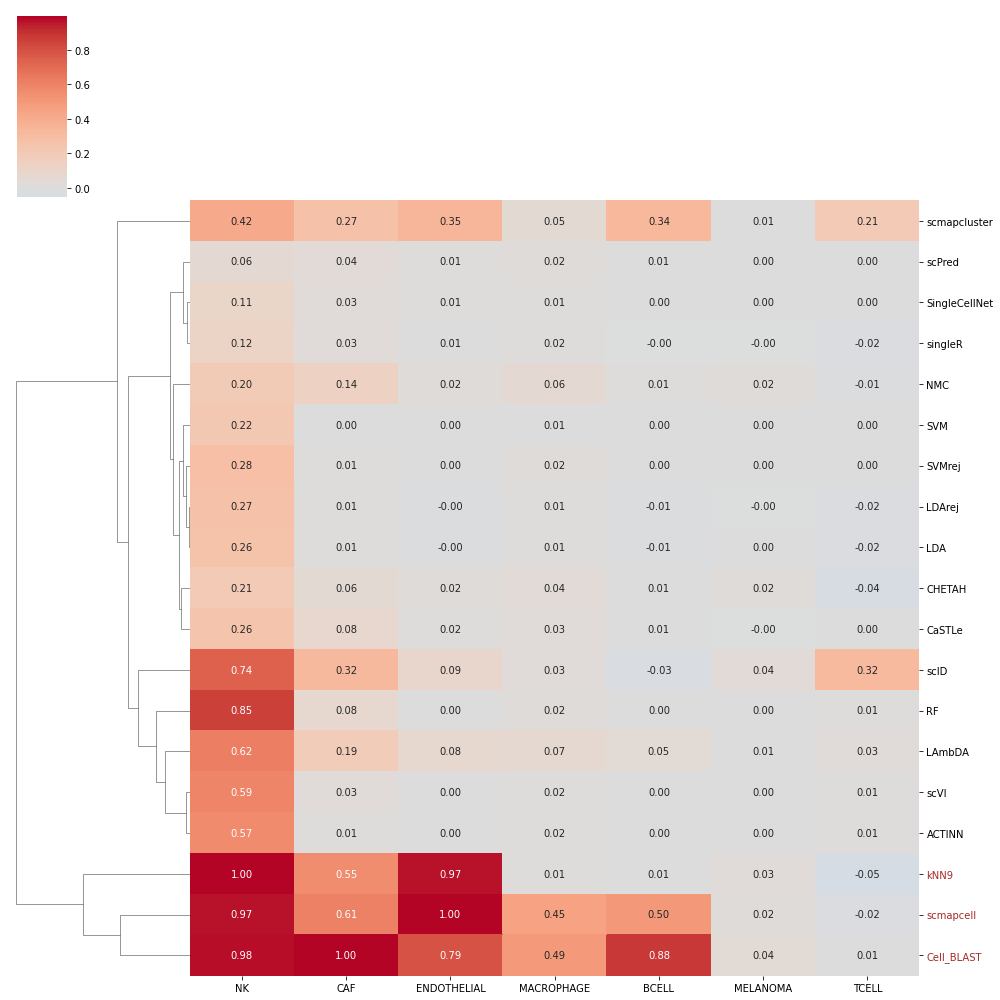

,class,support,cellprop
70,NK,51,0.012448
66,CAF,56,0.013669
67,ENDOTHELIAL,62,0.015133
68,MACROPHAGE,120,0.029290


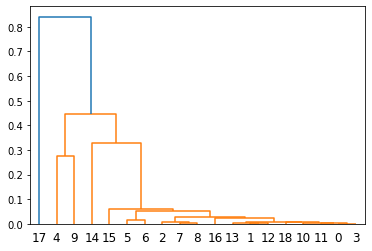

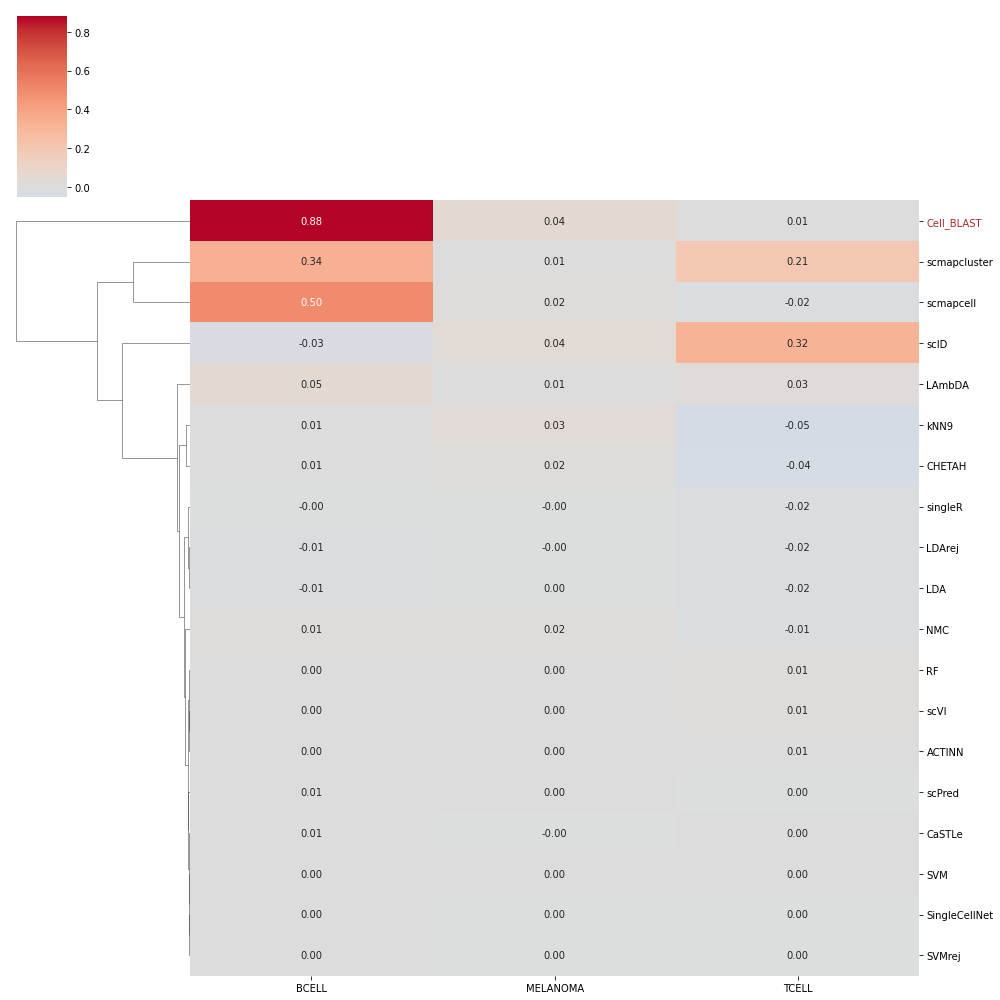

In [10]:
fulldf,sortdict = get_fulldf("/Users/erik/Documents/school/research/labelling_project/performance/seurat/tm_classification_report.tsv")
#cellrename = defaultdict(lambda)
cellrename2 = {'NK':'NK', 
              'BCELL':"BCELL", 
              'ENDO':"ENDOTHELIAL", 
              'CAF':"CAF", 
              'MACRO':"MACROPHAGE", 
              'TCELL':"TCELL", 
              'UNLABELED':'UNLABELED',
              'TUMOR':"MELANOMA"}
hmdf,hmdf2 = compare_subsampled('data/Tirosh_Melanoma_800.tsv',fulldf,sortdict,cellrename=cellrename2)
med_abs_df['Metastatic Melanoma'] = hmdf.abs().median(axis=1)
mean_abs_df['Metastatic Melanoma'] = hmdf.abs().mean(axis=1)
med_abs_df2['Metastatic Melanoma'] = hmdf2.abs().median(axis=1)
mean_abs_df2['Metastatic Melanoma'] = hmdf2.abs().mean(axis=1)

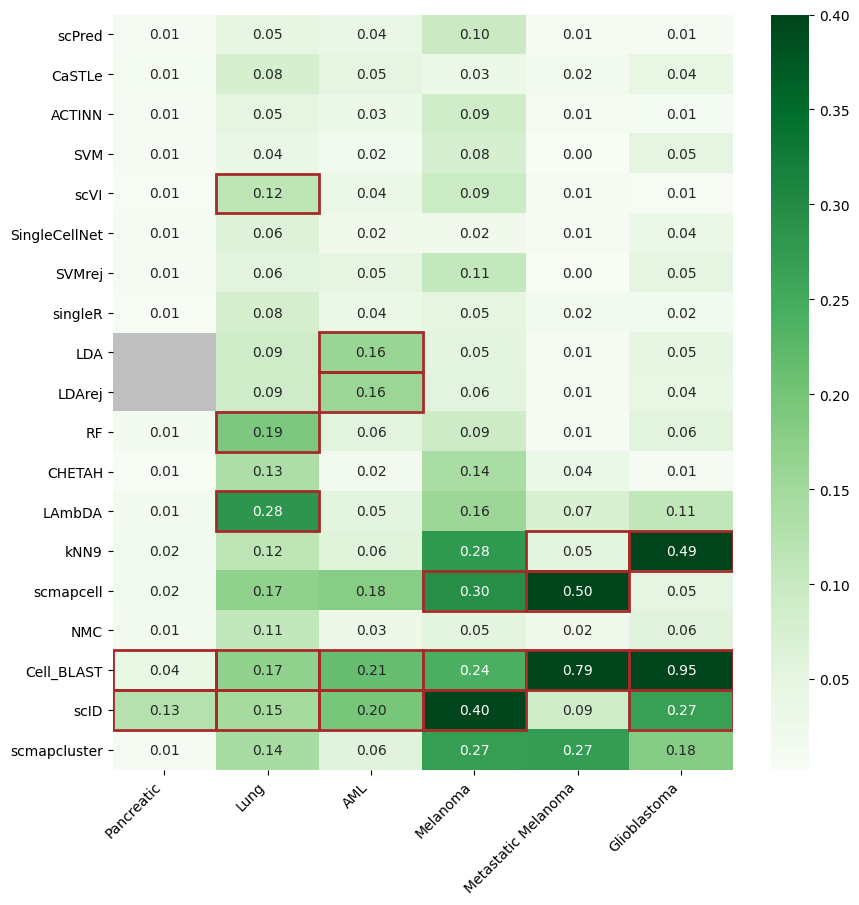

In [11]:
col_list = ['Pancreatic', 'Lung','AML','Melanoma','Metastatic Melanoma','Glioblastoma',]
#index_list = index_list[::-1]
med_abs_df = med_abs_df[col_list]
index_list = ['scPred','CaSTLe','ACTINN','SVM','scVI','SingleCellNet','SVMrej','singleR','LDA','LDArej',
              'RF','CHETAH','LAmbDA','kNN9','scmapcell','NMC','Cell_BLAST','scID','scmapcluster'
             ]
med_abs_df = med_abs_df.reindex(index_list)
fig,ax = plt.subplots(1,1,dpi=100)
colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
colour = sns.color_palette("Greens",as_cmap=True)
hm2 = sns.heatmap(med_abs_df,
                  #cmap='coolwarm', 
                  cmap=colour,
                  annot=True,
                  #center=0,
                  #vmin = -0.59,
                  vmax = 0.4,
                  fmt="1.2f",
                  ax = ax
                 )
hm2.set_facecolor('silver')
singleton_patches = [(0,17),(0,16),
                     (1,4),(1,10),(1,12),(1,16),(1,17),
                     (2,8),(2,9),(2,16),(2,17),
                     (3,14),(3,16),(3,17),
                     (4,13),(4,16),(4,14),
                     (5,13),(5,16),(5,17),
                    ]
for patch in singleton_patches:
    hm2.add_patch(Rectangle(patch,1,1,fill=False,edgecolor='brown',lw=2))
hm2.set_xticklabels(hm2.get_xticklabels(),rotation=45,horizontalalignment='right')
fig.set_figwidth(10)
fig.set_figheight(10)
plt.close()


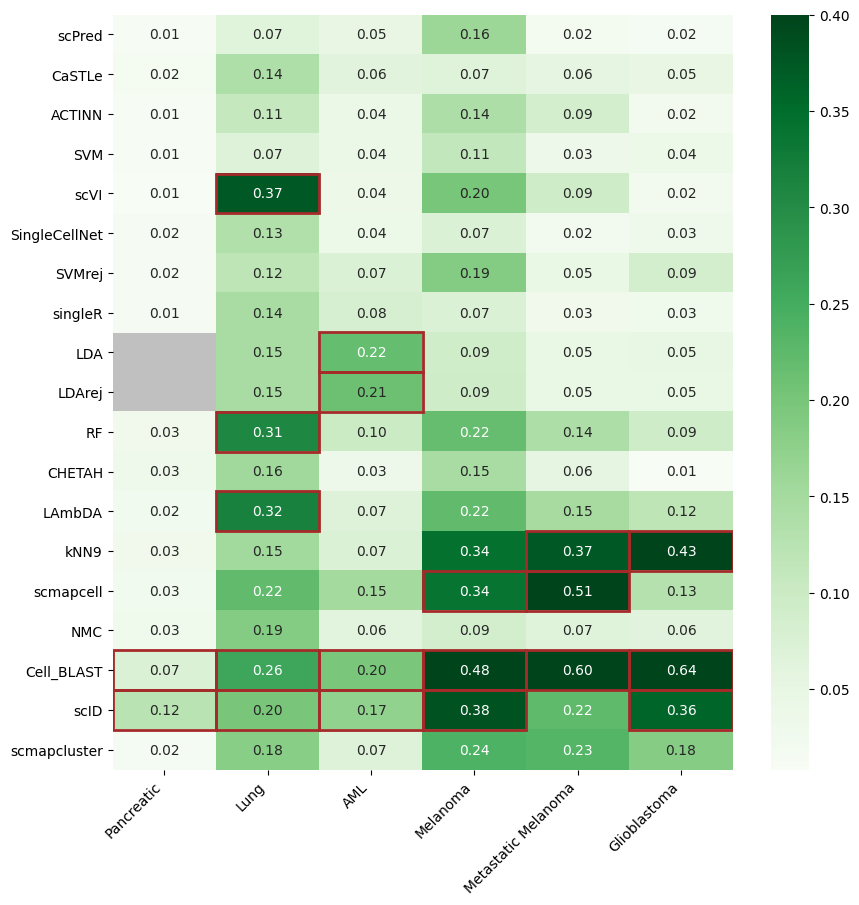

In [12]:
#MEAN
med_abs_df = mean_abs_df[col_list].copy()
index_list = ['scPred','CaSTLe','ACTINN','SVM','scVI','SingleCellNet','SVMrej','singleR','LDA','LDArej',
              'RF','CHETAH','LAmbDA','kNN9','scmapcell','NMC','Cell_BLAST','scID','scmapcluster'
             ]
med_abs_df = med_abs_df.reindex(index_list)
fig,ax = plt.subplots(1,1,dpi=100)
colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
colour = sns.color_palette("Greens",as_cmap=True)
hm2 = sns.heatmap(med_abs_df,
                  #cmap='coolwarm', 
                  cmap=colour,
                  annot=True,
                  #center=0,
                  #vmin = -0.59,
                  vmax = 0.4,
                  fmt="1.2f",
                  ax = ax
                 )
hm2.set_facecolor('silver')
singleton_patches = [(0,17),(0,16),
                     (1,4),(1,10),(1,12),(1,16),(1,17),
                     (2,8),(2,9),(2,16),(2,17),
                     (3,14),(3,16),(3,17),
                     (4,13),(4,16),(4,14),
                     (5,13),(5,16),(5,17),
                    ]
for patch in singleton_patches:
    hm2.add_patch(Rectangle(patch,1,1,fill=False,edgecolor='brown',lw=2))
hm2.set_xticklabels(hm2.get_xticklabels(),rotation=45,horizontalalignment='right')
fig.set_figwidth(10)
fig.set_figheight(10)
#plt.savefig('../plots/Figure_5/singletons.png')
plt.close()


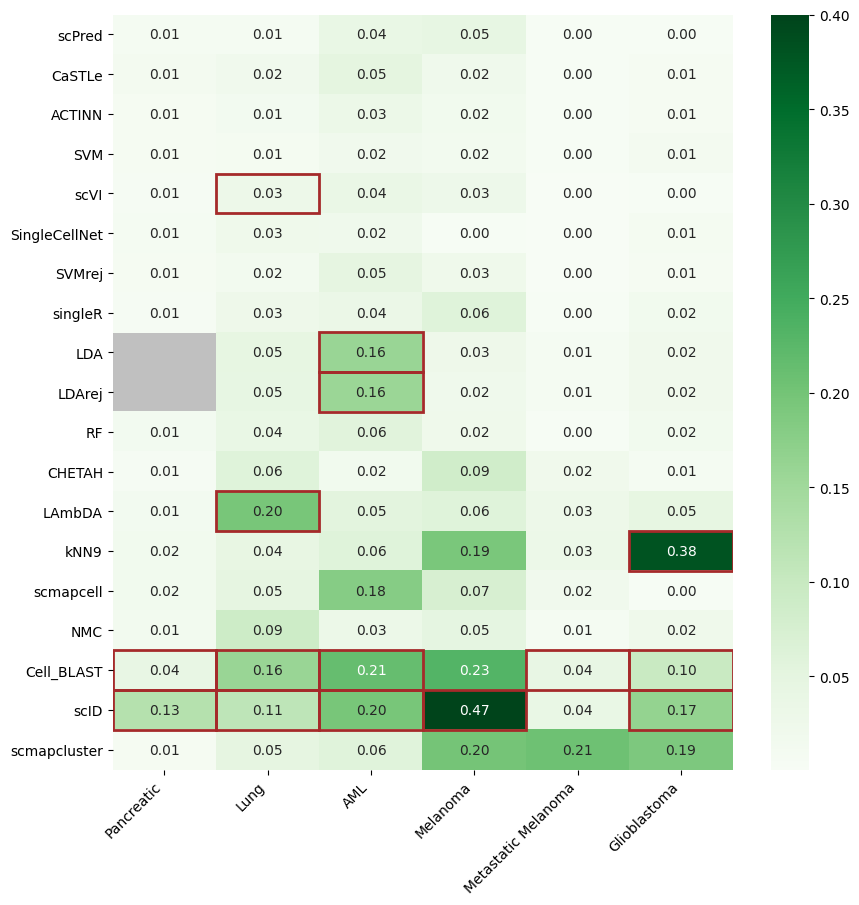

In [13]:
med_abs_df = med_abs_df2[col_list].copy()
index_list = ['scPred','CaSTLe','ACTINN','SVM','scVI','SingleCellNet','SVMrej','singleR','LDA','LDArej',
              'RF','CHETAH','LAmbDA','kNN9','scmapcell','NMC','Cell_BLAST','scID','scmapcluster'
             ]
med_abs_df = med_abs_df.reindex(index_list)
fig,ax = plt.subplots(1,1,dpi=100)
colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
colour = sns.color_palette("Greens",as_cmap=True)
hm2 = sns.heatmap(med_abs_df,
                  #cmap='coolwarm', 
                  cmap=colour,
                  annot=True,
                  #center=0,
                  #vmin = -0.59,
                  vmax = 0.4,
                  fmt="1.2f",
                  ax = ax
                 )
hm2.set_facecolor('silver')
singleton_patches = [(0,17),(0,16),
                     (1,4),(1,12),(1,16),(1,17),
                     (2,8),(2,9),(2,16),(2,17),
                     (3,17),
                     (4,16),
                     (5,13),(5,16),(5,17),
                    ]
for patch in singleton_patches:
    hm2.add_patch(Rectangle(patch,1,1,fill=False,edgecolor='brown',lw=2))
hm2.set_xticklabels(hm2.get_xticklabels(),rotation=45,horizontalalignment='right')
fig.set_figwidth(10)
fig.set_figheight(10)
#plt.savefig('../plots/Figure_5/singletons.png')
plt.close()


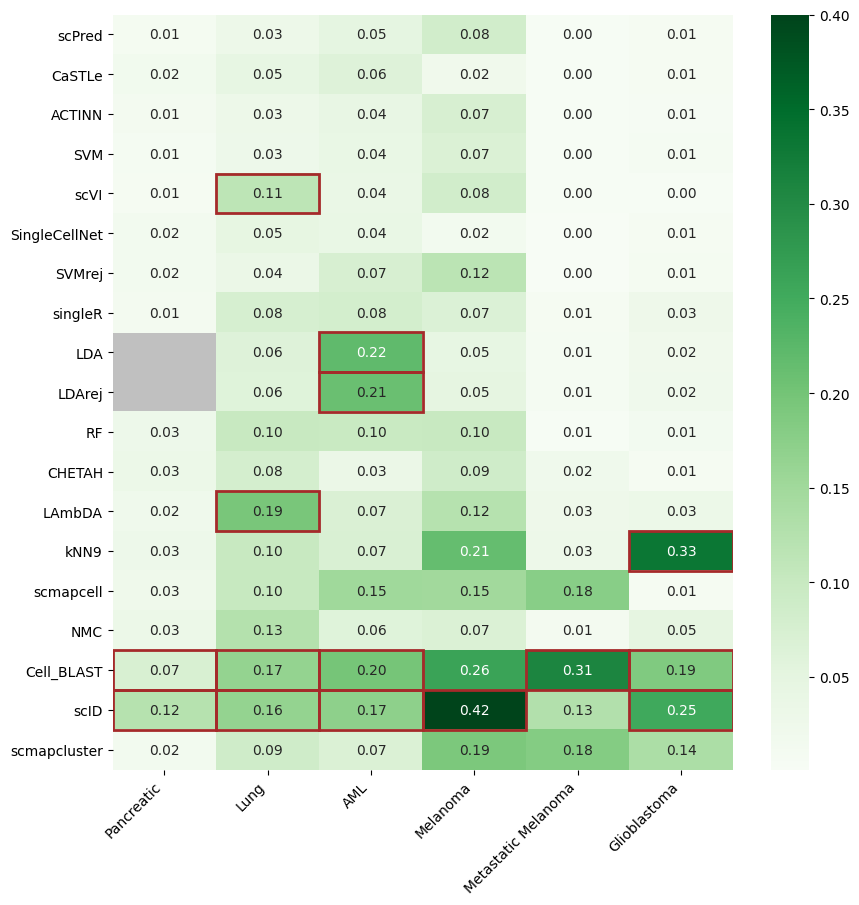

In [14]:
med_abs_df = mean_abs_df2[col_list]
index_list = ['scPred','CaSTLe','ACTINN','SVM','scVI','SingleCellNet','SVMrej','singleR','LDA','LDArej',
              'RF','CHETAH','LAmbDA','kNN9','scmapcell','NMC','Cell_BLAST','scID','scmapcluster'
             ]
med_abs_df = med_abs_df.reindex(index_list)
fig,ax = plt.subplots(1,1,dpi=100)
colour =  sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
colour = sns.color_palette("Greens",as_cmap=True)
hm2 = sns.heatmap(med_abs_df,
                  #cmap='coolwarm', 
                  cmap=colour,
                  annot=True,
                  #center=0,
                  #vmin = -0.59,
                  vmax = 0.4,
                  fmt="1.2f",
                  ax = ax
                 )
hm2.set_facecolor('silver')
singleton_patches = [(0,17),(0,16),
                     (1,4),(1,12),(1,16),(1,17),
                     (2,8),(2,9),(2,16),(2,17),
                     (3,17),
                     (4,16),
                     (5,13),(5,16),(5,17),
                    ]
for patch in singleton_patches:
    hm2.add_patch(Rectangle(patch,1,1,fill=False,edgecolor='brown',lw=2))
hm2.set_xticklabels(hm2.get_xticklabels(),rotation=45,horizontalalignment='right')
fig.set_figwidth(10)
fig.set_figheight(10)

plt.savefig('../plots/Figure_5/singletons.png', bbox_inches = 'tight')